In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Load in the data

In [287]:
streamflow_data = pd.read_csv("data/streamflow_data/Final_Processed_Station_Data_Watershed.csv")
streamflow_data.dropna(inplace=True)
streamflow_data.head(5)

C:\Users\tbwil\AppData\Local\Temp\ipykernel_10476\1023125811.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241) have mixed types. Specify dtype option on import or

,name,ADAMS RIVER NEAR SQUILAX,ALOUETTE RIVER NEAR HANEY,ANDERSON CREEK NEAR NELSON,ANSEDAGAN CREEK NEAR NEW AIYANSH,ARROW CREEK NEAR ERICKSON,ASH RIVER BELOW MORAN CREEK,ASHNOLA RIVER NEAR KEREMEOS,ATNARKO RIVER NEAR THE MOUTH,BABINE RIVER AT OUTLET OF NILKITKWA LAKE,...,VANCE CREEK BELOW DEAFIES CREEK,VASEUX CREEK ABOVE SOLCO CREEK,VERNON CREEK AT OUTLET OF KALAMALKA LAKE,WANNOCK RIVER AT OUTLET OF OWIKENO LAKE,WEST CREEK NEAR FORT LANGLEY,WEST KETTLE RIVER AT WESTBRIDGE,WEST KETTLE RIVER NEAR MCCULLOCH,WHITEMAN CREEK ABOVE BOULEAU CREEK,YALAKOM RIVER ABOVE ORE CREEK,ZEBALLOS RIVER AT MOOK PEAK
0,lat,50.93759,49.239,49.50195,55.12986,49.15912,49.36992,49.20763,52.36008,55.42654,...,50.28432,49.24928,50.23847,51.67917,49.14767,49.16981,49.70292,50.21222,50.91261,50.13569
1,lon,-119.65634,-122.57975,-117.26128,-129.35494,-116.45249,-124.98411,-119.99352,-126.00586,-126.69763,...,-118.94704,-119.32139,-119.26689,-127.17917,-122.53187,-118.97506,-119.09247,-119.53861,-122.23931,-126.82006
2,major_watershed,South Thompson River,Fraser River,Lower Kootenay River,Nass River,Lower Kootenay River,Vancouver Island (West) Rivers,Okanagan River,North Coast Rivers,Babine River,...,South Thompson River,Okanagan River,Okanagan River,North Coast Rivers,Fraser River,Kettle River,Kettle River,Okanagan River,Fraser River,Vancouver Island (West) Rivers
3,2011-01-01,21.10065052,3.950658369,0.026633333,0.175258698,0.49568895,12.29111538,1.690907985,-126.00586,15.4966629,...,0.067015878,0.083,0.075272787,99.95522759,0.072746181,1.596026005,0.401,0.04718573,1.238667116,0.176193638
4,2011-01-02,20.69611806,3.74086273,0.0249375,0.163091831,0.485078758,11.49209615,1.755803793,-120.3616256,15.25197908,...,0.067070577,0.081,0.07749122,94.00841842,0.052530297,1.552300933,0.392296896,0.047,1.195453978,0.147495593


In [288]:
station_lats = streamflow_data.iloc[0][1:]
station_lons = streamflow_data.iloc[1][1:]
watersheds = streamflow_data.iloc[2][1:]
station_names = streamflow_data.columns[1:]

# drop the first 3 rows
streamflow_data = streamflow_data.drop([0, 1, 2])
# drop the first column
streamflow_data = streamflow_data.drop(columns=["name"])
streamflow_data = streamflow_data.astype(float)
streamflow_data.head(5)

,ADAMS RIVER NEAR SQUILAX,ALOUETTE RIVER NEAR HANEY,ANDERSON CREEK NEAR NELSON,ANSEDAGAN CREEK NEAR NEW AIYANSH,ARROW CREEK NEAR ERICKSON,ASH RIVER BELOW MORAN CREEK,ASHNOLA RIVER NEAR KEREMEOS,ATNARKO RIVER NEAR THE MOUTH,BABINE RIVER AT OUTLET OF NILKITKWA LAKE,BAKER CREEK AT QUESNEL,...,VANCE CREEK BELOW DEAFIES CREEK,VASEUX CREEK ABOVE SOLCO CREEK,VERNON CREEK AT OUTLET OF KALAMALKA LAKE,WANNOCK RIVER AT OUTLET OF OWIKENO LAKE,WEST CREEK NEAR FORT LANGLEY,WEST KETTLE RIVER AT WESTBRIDGE,WEST KETTLE RIVER NEAR MCCULLOCH,WHITEMAN CREEK ABOVE BOULEAU CREEK,YALAKOM RIVER ABOVE ORE CREEK,ZEBALLOS RIVER AT MOOK PEAK
3,21.100651,3.950658,0.026633,0.175259,0.495689,12.291115,1.690908,-126.005860,15.496663,0.779153,...,0.067016,0.083,0.075273,99.955228,0.072746,1.596026,0.401000,0.047186,1.238667,0.176194
4,20.696118,3.740863,0.024938,0.163092,0.485079,11.492096,1.755804,-120.361626,15.251979,0.777872,...,0.067071,0.081,0.077491,94.008418,0.052530,1.552301,0.392297,0.047000,1.195454,0.147496
5,20.412194,3.620703,0.023571,0.166408,0.486131,10.892279,1.819793,-114.717391,15.246768,0.772798,...,0.067069,0.079,0.079711,87.546224,0.036934,1.541753,0.383060,0.061246,1.150701,0.136078
6,20.203941,3.528421,0.024729,0.178720,0.498147,10.455154,1.879251,-109.073157,15.616654,0.768037,...,0.067029,0.077,0.082849,82.198203,0.035229,1.570497,0.373180,0.066975,1.107009,0.183736
7,20.193618,5.366124,0.024850,0.188595,0.509200,11.024510,1.930552,-103.428922,16.034901,0.763594,...,0.066954,0.075,0.087453,85.333824,0.458728,1.617611,0.362546,0.063745,1.066981,2.734586


In [289]:
# load in the precipitation and temperature data
rainfall_data = np.load("data/weather_data/rainfall_data.npy").astype(float)
snowfall_data = np.load("data/weather_data/snowfall_data.npy").astype(float)
max_temp_data = np.load("data/weather_data/max_temp_data_interp.npy").astype(float)
min_temp_data = np.load("data/weather_data/min_temp_data_interp.npy").astype(float)

# Split the data into training, validation, and test sets

In [290]:
# standardize the data
rainfall_data = (rainfall_data - np.mean(rainfall_data)) / np.std(rainfall_data)
snowfall_data = (snowfall_data - np.mean(snowfall_data)) / np.std(snowfall_data)
max_temp_data = (max_temp_data - np.mean(max_temp_data)) / np.std(max_temp_data)
min_temp_data = (min_temp_data - np.mean(min_temp_data)) / np.std(min_temp_data)
streamflow_data = (streamflow_data - streamflow_data.mean()) / streamflow_data.std()
streamflow_data = streamflow_data.to_numpy()

In [72]:
# define the fractions
train_frac = 7/9
val_frac = 1/9
test_frac = 1/9

assert train_frac + val_frac + test_frac == 1

# define the indices for the train, validation, and test sets
train_idx = int(train_frac * len(streamflow_data))
val_idx = int((train_frac + val_frac) * len(streamflow_data))
n_train = train_idx
n_val = val_idx - train_idx
n_test = len(streamflow_data) - val_idx

assert n_train + n_val + n_test == len(streamflow_data)

# standardize the data based on the training set
# rainfall_data = (rainfall_data - np.mean(rainfall_data[:train_idx])) / np.std(rainfall_data[:train_idx])
# snowfall_data = (snowfall_data - np.mean(snowfall_data[:train_idx])) / np.std(snowfall_data[:train_idx])
# max_temp_data = (max_temp_data - np.mean(max_temp_data[:train_idx])) / np.std(max_temp_data[:train_idx])
# min_temp_data = (min_temp_data - np.mean(min_temp_data[:train_idx])) / np.std(min_temp_data[:train_idx])
# streamflow_data = (streamflow_data - streamflow_data.iloc[:train_idx].mean()) / streamflow_data.iloc[:train_idx].std()
# streamflow_data = streamflow_data.to_numpy()

In [126]:
# define the time window
n_groups = 7
group_size = 14
time_window = n_groups * group_size
n_channels = 4
grid_shape = rainfall_data.shape[1:]
n_stations = streamflow_data.shape[1]

combine_multiple_groups = False
if combine_multiple_groups:
    pts_per_group = 7
    group_sizes = [1,7,14,30]
    n_groups = len(group_sizes) * pts_per_group
    time_window = np.sum(group_sizes) * pts_per_group
    start_idxs = np.cumsum([0] + [pts_per_group * size for size in group_sizes])

# create the training, validation, and test sets
x_intermediate = np.empty(np.shape(rainfall_data) + (4,), dtype='single')
for i, data in enumerate([rainfall_data, snowfall_data, max_temp_data, min_temp_data]):
    x_intermediate[:,:,:,i] = data
x_intermediate = x_intermediate[:,:,:,:n_channels]

def gen_train():
    for i in range(n_train - time_window):
        if combine_multiple_groups:
            xsizes = [x_intermediate[i+start_idxs[j]:i+start_idxs[j+1]].reshape(pts_per_group, *grid_shape, n_channels, group_sizes[j]).mean(axis=-1) for j in range(len(group_sizes))]
            xx = np.concatenate(xsizes, axis=0)
        else:
            xx = tf.convert_to_tensor(x_intermediate[i:i+time_window].reshape(n_groups, *grid_shape, n_channels, group_size).mean(axis=-1))
        yy = streamflow_data[time_window + i,:]
        yield (xx, yy)

def gen_val():
    for i in range(n_val):
        if combine_multiple_groups:
            xsizes = [x_intermediate[i+n_train-time_window+start_idxs[j]:i+n_train-time_window+start_idxs[j+1]].reshape(pts_per_group, *grid_shape, n_channels, group_sizes[j]).mean(axis=-1) for j in range(len(group_sizes))]
            xx = np.concatenate(xsizes, axis=0)
        else:
            xx = tf.convert_to_tensor(x_intermediate[i+n_train-time_window:i+n_train].reshape(n_groups, *grid_shape, n_channels, group_size).mean(axis=-1))
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

def gen_test():
    for i in range(n_test):
        if combine_multiple_groups:
            xsizes = [x_intermediate[i+val_idx-time_window+start_idxs[j]:i+val_idx+start_idxs[j+1]].reshape(pts_per_group, *grid_shape, n_channels, group_sizes[j]).mean(axis=-1) for j in range(len(group_sizes))]
            xx = np.concatenate(xsizes, axis=0)
        else:
            xx = tf.convert_to_tensor(x_intermediate[i+val_idx-time_window:i+val_idx].reshape(n_groups, *grid_shape, n_channels, group_size).mean(axis=-1))
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

# Create a model

In [127]:
def create_model(learning_rate=0.001):
    # Input layer
    cnn_input = layers.Input(shape=(n_groups, *grid_shape, n_channels), name="Weather_Data_Input")
    
    # TimeDistributed CNN
    cnn = layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))(cnn_input)
    cnn = layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))(cnn)
    cnn = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(cnn)
    cnn = layers.TimeDistributed(layers.Flatten())(cnn)  # Flatten the grid

    # LSTM for temporal patterns
    lstm = layers.LSTM(32, return_sequences=False)(cnn)

    # Fully connected layers
    dense = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(lstm)
    dense = layers.Dropout(0.4)(dense)  # Dropout for regularization
    output = layers.Dense(n_stations, activation='linear', name="Streamflow_Output")(dense)

    # Model definition
    model = models.Model(inputs=cnn_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

model = create_model()
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Weather_Data_Input (InputLayer) │ (None, 7, 22, 37, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 7, 22, 37, 8)   │           296 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 7, 22, 37, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 7, 11, 18, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 7, 3168)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Streamflow_Output (Dense)       │ (None, 241)            │        15,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,969 (1.64 MB)

 Trainable params: 428,969 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

### Model rationale:
Lighter Convolutions:
* Starting with 8 filters in the first Conv2D reduces computational overhead while still extracting features.

Pooling for Dimensionality Reduction:
* The MaxPooling2D layer halves spatial dimensions, reducing memory and compute needs.

Flatten Instead of Global Pooling:
* Retains more detailed spatial features by flattening instead of directly aggregating with GlobalMaxPooling2D.

Single LSTM Layer:
* A single LSTM with 64 units balances complexity and efficiency.

Dropout Regularization:
* A dropout rate of 0.2 in the dense layers mitigates overfitting without significant computational cost.

Simplified Dense Layers:
* One hidden layer in the Dense block keeps the architecture compact.

# Train and save the model

In [128]:
batch_size = 16
learning_rate = 0.001
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                             patience=10,
                                             restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.1,
                                                patience=5,
                                                verbose=1,
                                                mode='min')

print(f"Training model with {group_size} day groups and {n_groups} groups")
print(f"Using {n_channels} data channels")
train_dataset = tf.data.Dataset.from_generator(
    gen_train,
    (tf.float16, tf.float16),
    (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).shuffle(n_train).batch(batch_size)

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).shuffle(n_val).batch(batch_size)

model = create_model(learning_rate)
model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    verbose=1,
    # callbacks=[early_stopping, reduce_lr]
    callbacks=[reduce_lr]
)

# save the model
if combine_multiple_groups:
    model.save(f"models/test_model_composite_{n_channels}ch.keras")
model.save(f"models/test_model_group_{group_size}x{n_groups}days_{n_channels}ch.keras")

Training model with 14 day groups and 7 groups
Using 4 data channels
Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - loss: 1.2493 - val_loss: 0.4808 - learning_rate: 0.0010
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.5949 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.5228 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.4842 - val_loss: 0.3976 - learning_rate: 0.0010
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.4367 - val_loss: 0.4162 - learning_rate: 0.0010
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.4124 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.4338 - val_loss: 0.4333 - learning_rate: 0.0010
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.4003 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 9/20
153/154 ━━━━━━━━━━━━━━━━

# Plot the results

In [14]:
def compute_nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


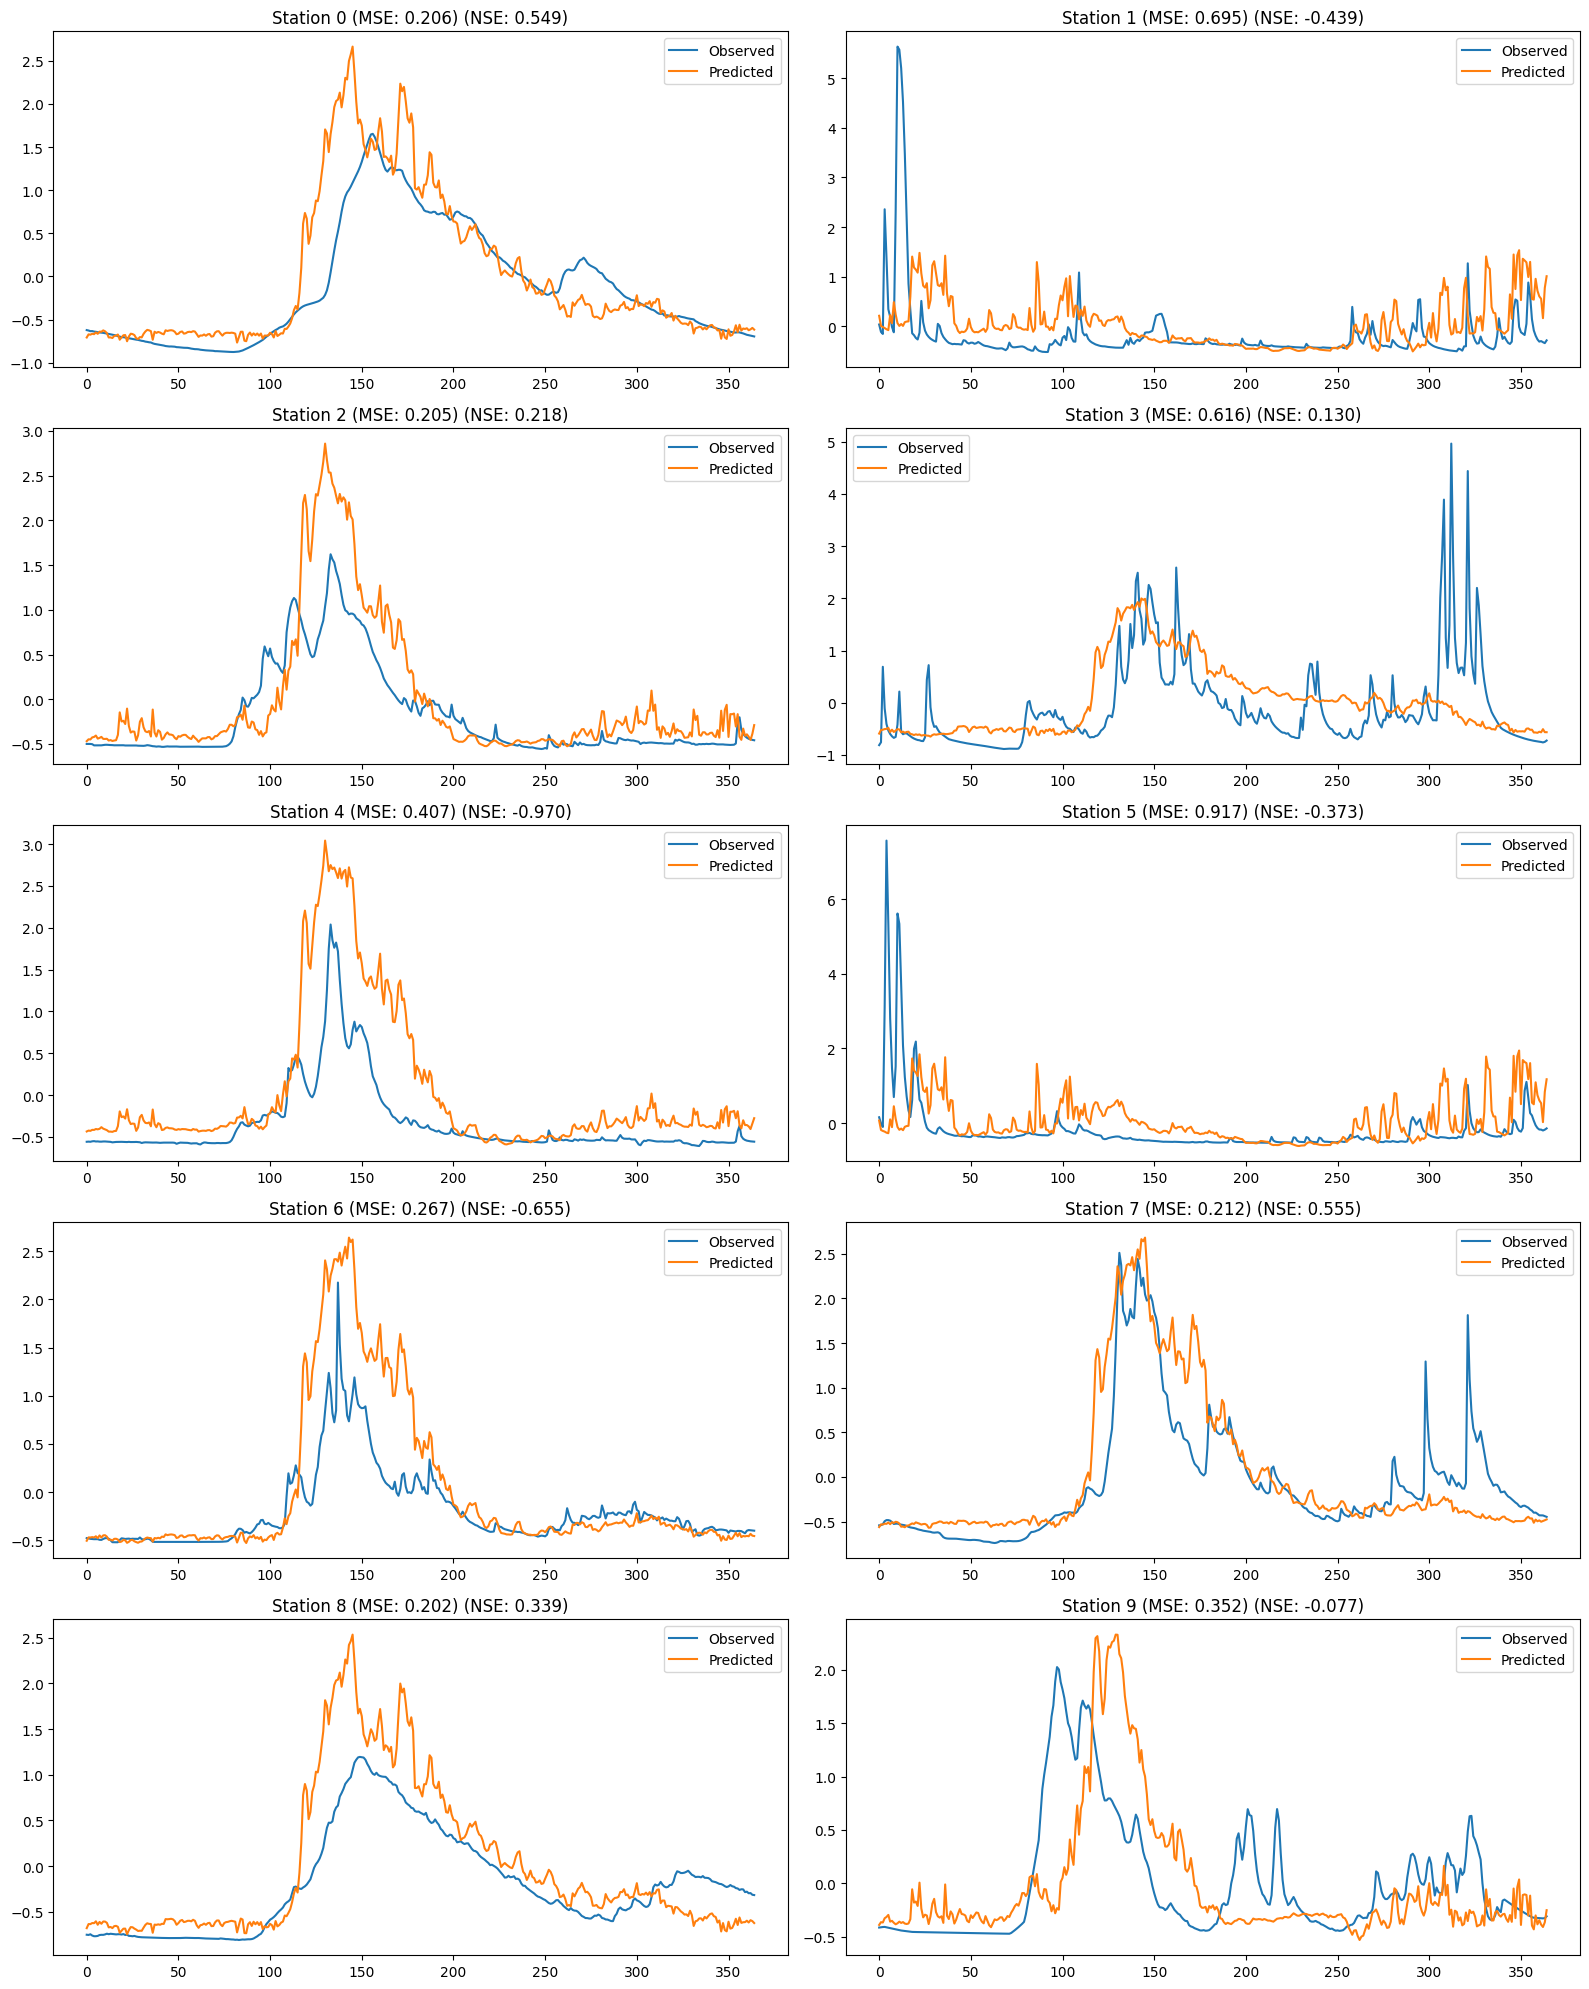

In [132]:
# plot the model predictions for the first 20 stations using subplots
n_plot = 10

batch_size = 16
n_groups = 7
group_size = 14
time_window = n_groups * group_size
n_channels = 4

x_intermediate = np.empty(np.shape(rainfall_data) + (4,), dtype='single')
for i, data in enumerate([rainfall_data, snowfall_data, max_temp_data, min_temp_data]):
    x_intermediate[:,:,:,i] = data
x_intermediate = x_intermediate[:,:,:,:n_channels]

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).batch(batch_size)

if combine_multiple_groups:
    model = tf.keras.models.load_model(f"models/test_model_composite_{n_channels}ch.keras")
else:
    model = tf.keras.models.load_model(f"models/test_model_group_{group_size}x{n_groups}days_{n_channels}ch.keras")

predictions = model.predict(val_dataset)
y_true = np.empty((n_val, n_stations))
for i, (_, y) in enumerate(gen_val()):
    y_true[i] = y

fig, axs = plt.subplots(n_plot // 2, 2, figsize=(16, n_plot * 2))
for i in range(n_plot):
    mse = np.mean((y_true[:, i] - predictions[:, i]) ** 2)
    nse = compute_nse(y_true[:, i], predictions[:, i])
    station = i
    ax = axs[i // 2, i % 2]
    ax.plot(y_true[:, station], label='Observed')
    ax.plot(predictions[:, station], label='Predicted')
    ax.set_title(f"Station {station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
    ax.legend()
plt.tight_layout()
plt.show()

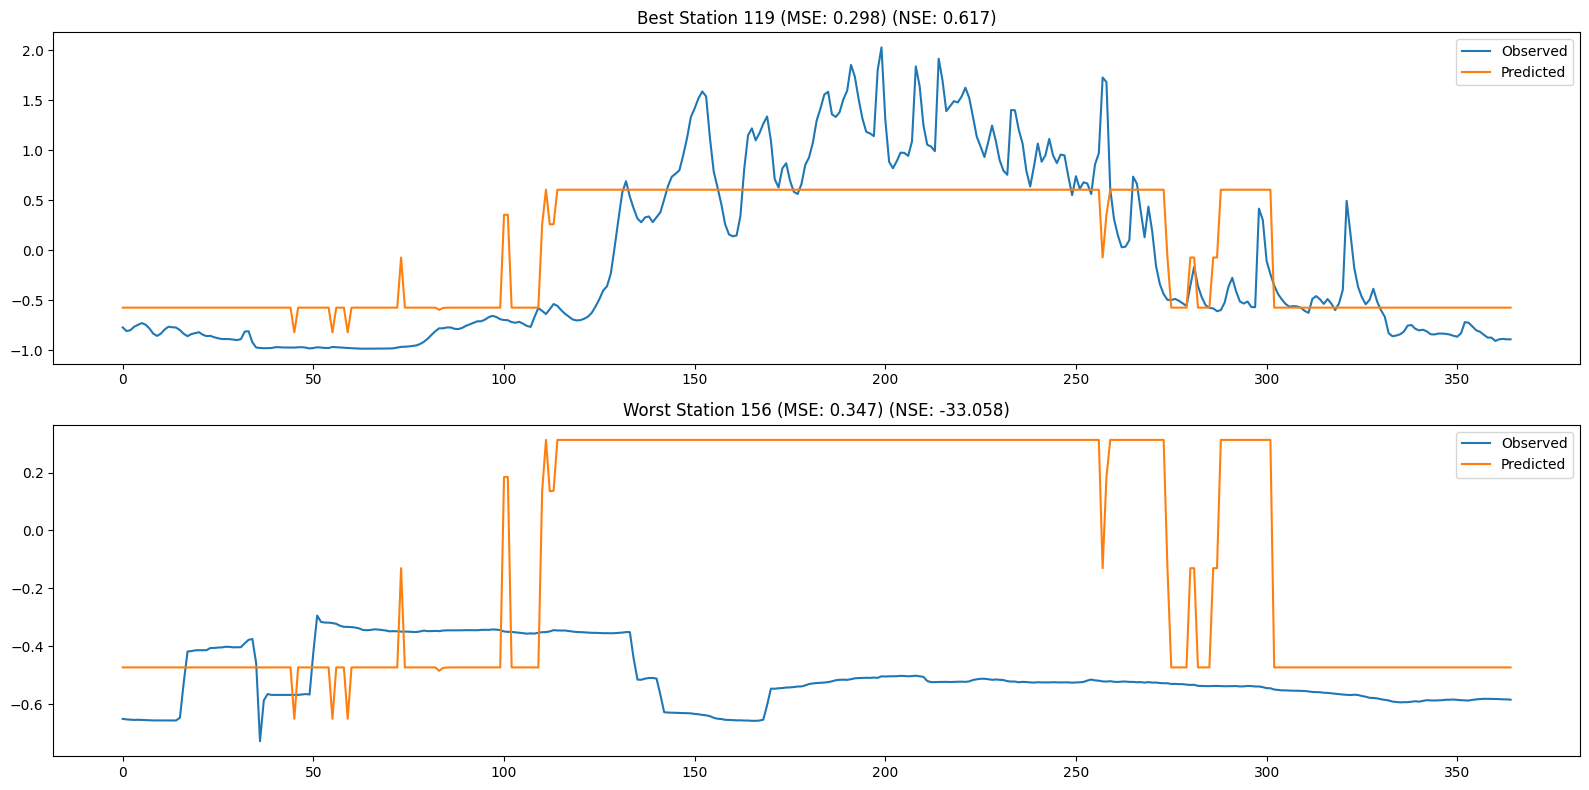

Mean NSE: -0.179


In [82]:
# plot the best and worst predictions by NSE
best_station = np.argmax([compute_nse(y_true[:, i], predictions[:, i]) for i in range(n_stations)])
worst_station = np.argmin([compute_nse(y_true[:, i], predictions[:, i]) for i in range(n_stations)])

# best_station = np.argmin(np.mean((y_true - predictions) ** 2, axis=0))
# worst_station = np.argmax(np.mean((y_true - predictions) ** 2, axis=0))

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
mse = np.mean((y_true[:, best_station] - predictions[:, best_station]) ** 2)
nse = compute_nse(y_true[:, best_station], predictions[:, best_station])
axs[0].plot(y_true[:, best_station], label='Observed')
axs[0].plot(predictions[:, best_station], label='Predicted')
axs[0].set_title(f"Best Station {best_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[0].legend()

mse = np.mean((y_true[:, worst_station] - predictions[:, worst_station]) ** 2)
nse = compute_nse(y_true[:, worst_station], predictions[:, worst_station])
axs[1].plot(y_true[:, worst_station], label='Observed')
axs[1].plot(predictions[:, worst_station], label='Predicted')
axs[1].set_title(f"Worst Station {worst_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[1].legend()
plt.tight_layout()
plt.show()

# print the mean NSE
mean_nse = np.mean([compute_nse(y_true[:, i], predictions[:, i]) for i in range(n_stations)])
print(f"Mean NSE: {mean_nse:.3f}")

# Plot the test model performances

In [150]:
# collect all of the test_model_group files
import os
import re

model_files = [f for f in os.listdir("models") if f.startswith("test_model_group")]

# extract the group size, number of groups, and number of channels from the file name
model_info = []
for model_file in model_files:
    group_size, n_groups, n_channels = [int(s) for s in re.findall(r'\d+', model_file)]
    if n_channels == 4:
        model_info.append((group_size, n_groups, n_channels))

# load the models and compute the predictions
predictions = []
test_preds = []
test_true = []
y_true = []
mean_mse = []
mean_nse = []
all_nse = []
for (group_size, n_groups, n_channels) in model_info:
    time_window = n_groups * group_size
    val_dataset = tf.data.Dataset.from_generator(
        gen_val,
        (tf.float16, tf.float16),
        (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).batch(batch_size)

    test_dataset = tf.data.Dataset.from_generator(
        gen_test,
        (tf.float16, tf.float16),
        (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).batch(batch_size)

    model = tf.keras.models.load_model(f"models/test_model_group_{group_size}x{n_groups}days_{n_channels}ch.keras")

    predictions.append(model.predict(val_dataset))
    test_preds.append(model.predict(test_dataset))
    test_true.append(np.array([y for _, y in gen_test()]))
    y_true.append(np.array([y for _, y in gen_val()]))
    mean_mse.append(np.mean((y_true[-1] - predictions[-1]) ** 2))
    mean_nse.append(np.mean([compute_nse(y_true[-1][:, i], predictions[-1][:, i]) for i in range(n_stations)]))
    all_nse.append(np.array([compute_nse(y_true[-1][:, i], predictions[-1][:, i]) for i in range(n_stations)]))

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
      3/Unknown 0s 39ms/step

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

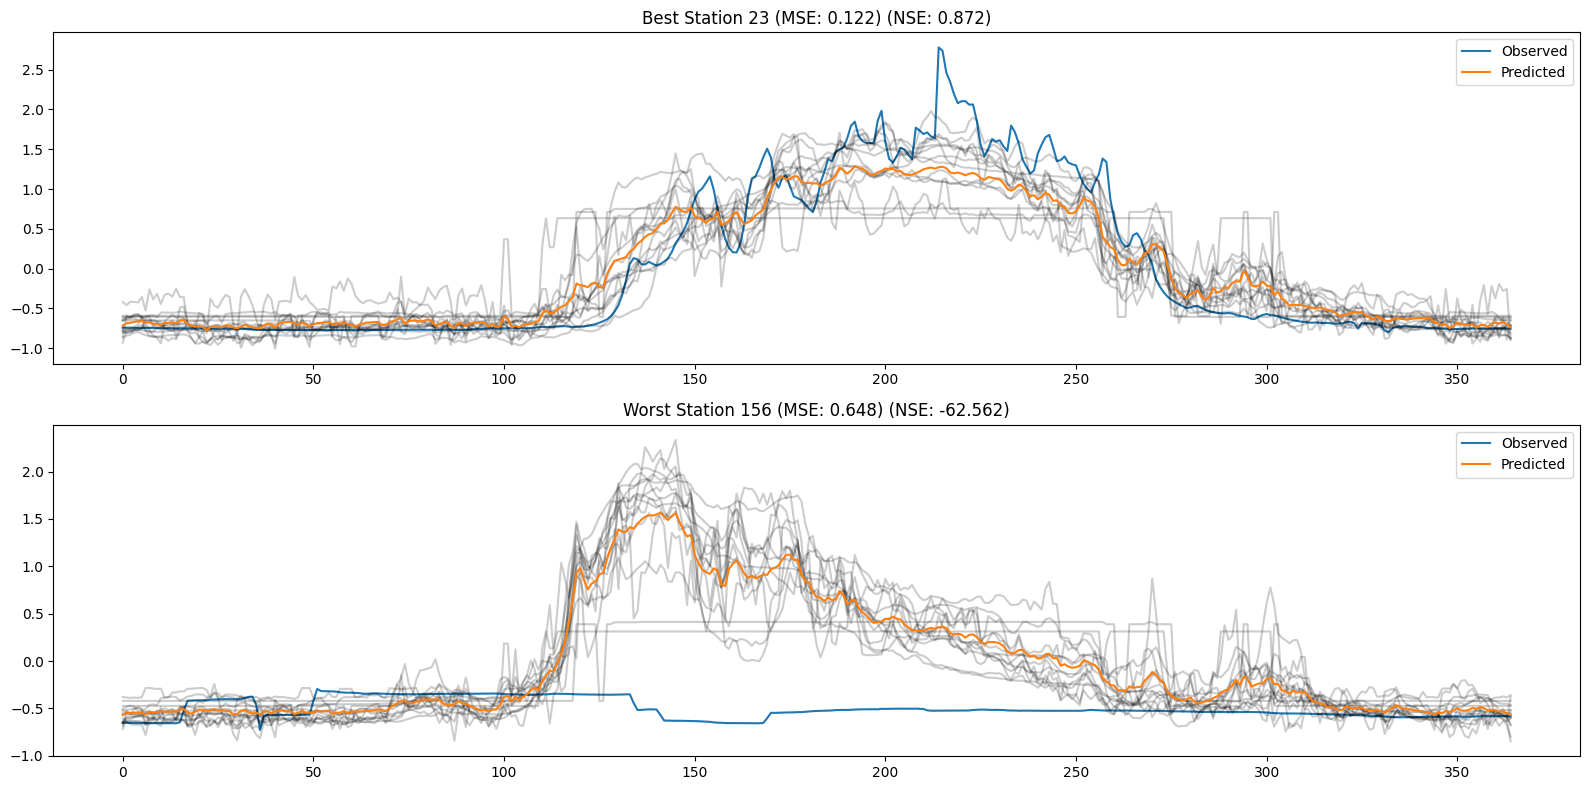

0.40488929181464384


In [76]:
# plot the average prediction as an ensemble
ensemble_predictions = np.mean(predictions, axis=0)
ensemble_mse = np.mean((y_true[0] - ensemble_predictions) ** 2)
ensemble_nse = compute_nse(y_true[0], ensemble_predictions)

# plot the best and worst predictions by NSE
best_station = np.argmax([compute_nse(y_true[0][:, i], ensemble_predictions[:, i]) for i in range(n_stations)])
worst_station = np.argmin([compute_nse(y_true[0][:, i], ensemble_predictions[:, i]) for i in range(n_stations)])

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
mse = np.mean((y_true[0][:, best_station] - ensemble_predictions[:, best_station]) ** 2)
nse = compute_nse(y_true[0][:, best_station], ensemble_predictions[:, best_station])
axs[0].plot(y_true[0][:, best_station], label='Observed')
axs[0].plot(np.array(predictions).T[best_station], c='k', alpha=0.2)
axs[0].plot(ensemble_predictions[:, best_station], label='Predicted')
axs[0].set_title(f"Best Station {best_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[0].legend()

mse = np.mean((y_true[0][:, worst_station] - ensemble_predictions[:, worst_station]) ** 2)
nse = compute_nse(y_true[0][:, worst_station], ensemble_predictions[:, worst_station])
axs[1].plot(y_true[0][:, worst_station], label='Observed')
axs[1].plot(np.array(predictions).T[worst_station], c='k', alpha=0.2)
axs[1].plot(ensemble_predictions[:, worst_station], label='Predicted')
axs[1].set_title(f"Worst Station {worst_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[1].legend()
plt.tight_layout()
plt.show()

# print the mean NSE
print(ensemble_nse)

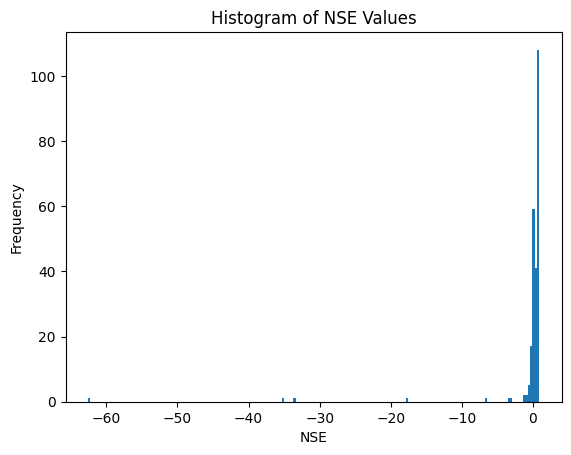

In [95]:
# create a histogram of the NSE values
y_true_arr = np.array(y_true)
nse_per_station = np.array([compute_nse(y_true[:,i], ensemble_predictions[:, i]) for i in range(n_stations)])
plt.hist(nse_per_station, bins=200)
plt.title("Histogram of NSE Values")
plt.xlabel("NSE")
plt.ylabel("Frequency")
plt.show()

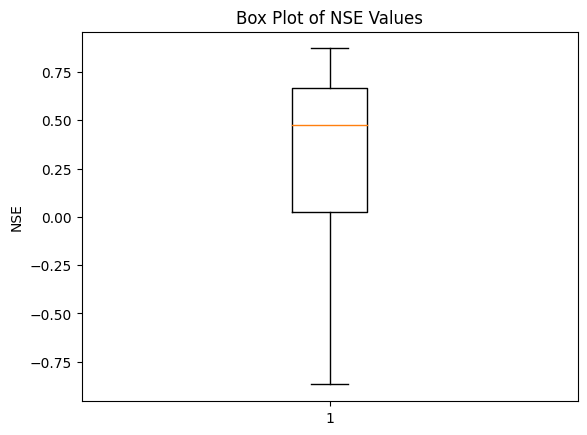

In [98]:
# create a box plot without outliers
plt.boxplot(nse_per_station, showfliers=False)
plt.title("Box Plot of NSE Values")
plt.ylabel("NSE")
plt.show()

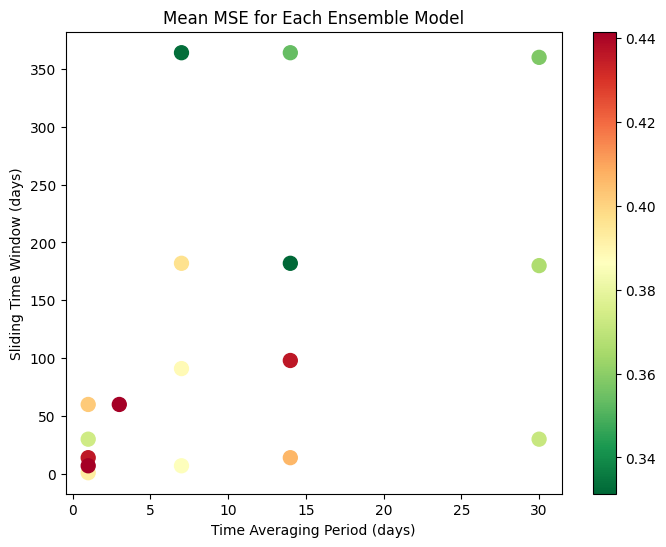

In [131]:
# plot a heatmap of the mean NSE for each model
group_sizes = [group_size for group_size, _, _ in model_info]
time_windows = [group_size * n_groups for group_size, n_groups, _ in model_info]

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(group_sizes, time_windows, c=mean_mse, cmap='RdYlGn_r', s=100)
plt.xlabel("Time Averaging Period (days)")
plt.ylabel("Sliding Time Window (days)")
plt.title("Mean MSE for Each Ensemble Model")
plt.colorbar()
plt.show()

# Evaluate the ensemble model

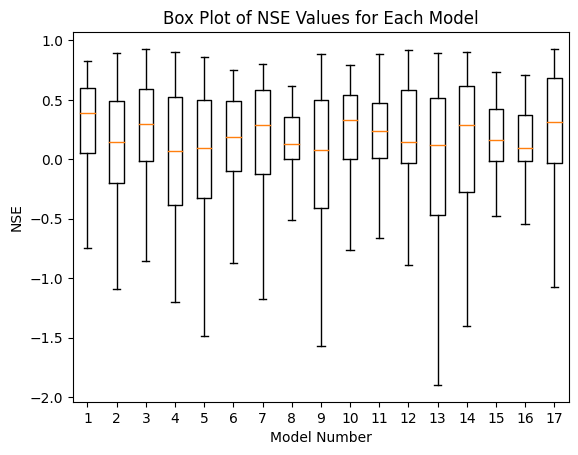

In [ ]:
# create a box plot of the NSE values for each model
plt.boxplot(all_nse, showfliers=False)
plt.title("Box Plot of Validation NSE Values for Each Model")
plt.xlabel("Model Number")
plt.ylabel("NSE")
plt.show()

In [143]:
# drop the two models with the lowest Q1 NSE
model_info = np.array(model_info)
all_nse = np.array(all_nse)
q1_nse = np.percentile(all_nse, 25, axis=1)
q1_nse_idx = np.argsort(q1_nse)
ensemble_idx = q1_nse_idx[2:]

In [149]:
all_ens_predictions = np.stack([predictions[i] for i in ensemble_idx])
y_true = np.array(y_true)
ensemble_predictions = np.mean(all_ens_predictions, axis=0)
all_ens_predictions.shape

(15, 365, 241)

In [ ]:
all_ens_predictions_test = np.stack([test_preds[i] for i in ensemble_idx])
test_true = np.array(test_true)
ensemble_predictions_test = np.mean(all_ens_predictions_test, axis=0)
all_ens_predictions_test.shape

(15, 366, 241)

In [160]:
test_true = test_true[0]
test_true.shape

(366, 241)

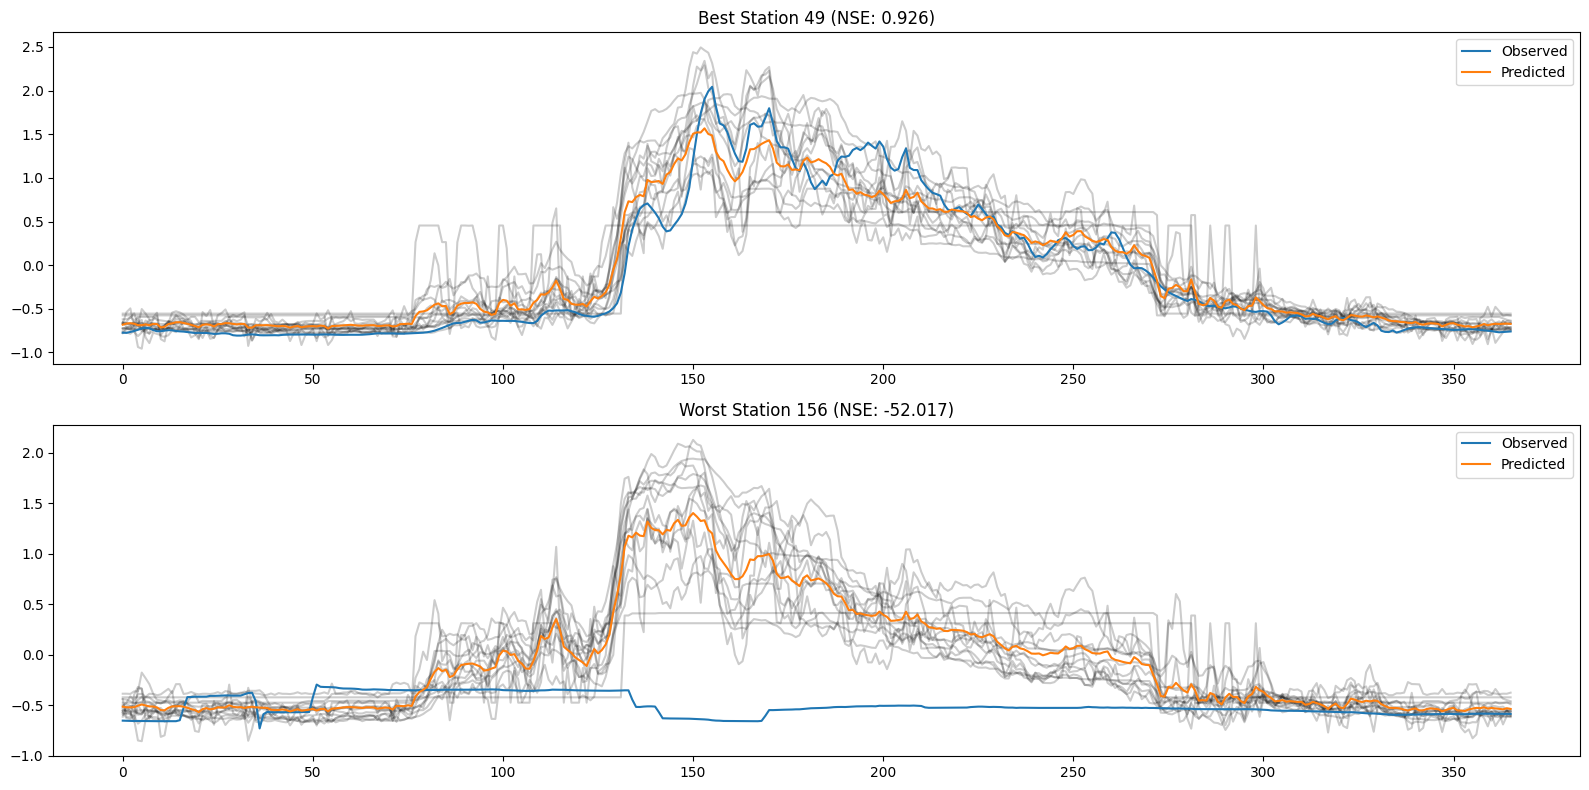

In [236]:
# plot the best and worst predictions by NSE
best_station = np.argmax([compute_nse(test_true[:, i], ensemble_predictions_test[:, i]) for i in range(n_stations)])
worst_station = np.argmin([compute_nse(test_true[:, i], ensemble_predictions_test[:, i]) for i in range(n_stations)])

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
nse = compute_nse(test_true[:, best_station], ensemble_predictions_test[:, best_station])
axs[0].plot(all_ens_predictions_test[:,:,best_station].T, c='k', alpha=0.2)
axs[0].plot(test_true[:, best_station], label='Observed')
axs[0].plot(ensemble_predictions_test[:, best_station], label='Predicted')
axs[0].set_title(f"Best Station {best_station} (NSE: {nse:.3f})")
axs[0].legend()

nse = compute_nse(test_true[:, worst_station], ensemble_predictions_test[:, worst_station])
axs[1].plot(all_ens_predictions_test[:,:,worst_station].T, c='k', alpha=0.2)
axs[1].plot(test_true[:, worst_station], label='Observed')
axs[1].plot(ensemble_predictions_test[:, worst_station], label='Predicted')
axs[1].set_title(f"Worst Station {worst_station} (NSE: {nse:.3f})")
axs[1].legend()
plt.tight_layout()
plt.show()

In [161]:
# print the mean NSE
mean_ensemble_nse_test = np.array([compute_nse(test_true[:,i], ensemble_predictions_test[:,i]) for i in range(n_stations)])
mean_ensemble_nse_test.shape

(241,)

In [258]:
mean_ensemble_nse_test_no_outliers = mean_ensemble_nse_test[mean_ensemble_nse_test > -5]
mean_ensemble_nse_test_no_outliers.shape

(236,)

In [260]:
np.mean(mean_ensemble_nse_test_no_outliers)

0.5021449654408552

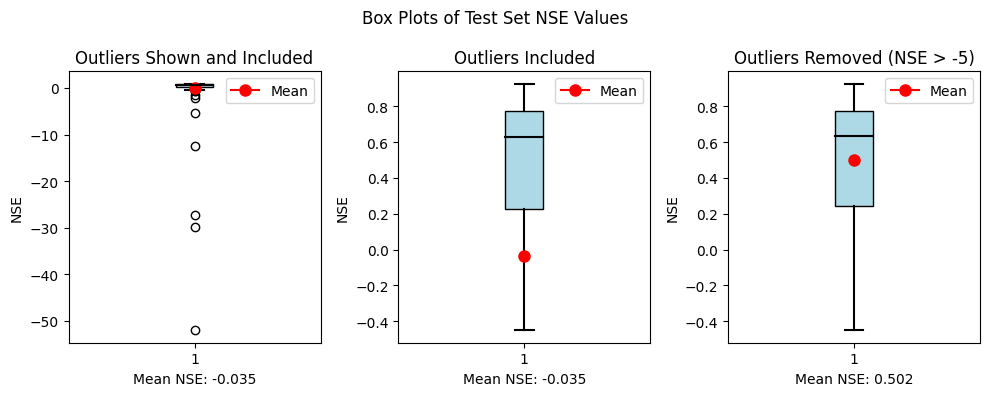

In [271]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Plot with outliers removed but without fliers
axs[0].boxplot(mean_ensemble_nse_test, showfliers=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black', linewidth=1.5),
               capprops=dict(color='black', linewidth=1.5), medianprops=dict(color='black', linewidth=1.5))
mean_value = np.mean(mean_ensemble_nse_test)
axs[0].plot(1, mean_value, marker='o', color='red', label="Mean", markersize=8)  # Overlay the mean
axs[0].set_title("Outliers Shown and Included")
axs[0].set_xlabel("Mean NSE: {:.3f}".format(mean_value))
axs[0].set_ylabel("NSE")
axs[0].legend()

# Plot with outliers removed but without fliers
axs[1].boxplot(mean_ensemble_nse_test, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black', linewidth=1.5),
               capprops=dict(color='black', linewidth=1.5), medianprops=dict(color='black', linewidth=1.5))
mean_value = np.mean(mean_ensemble_nse_test)
axs[1].plot(1, mean_value, marker='o', color='red', label="Mean", markersize=8)  # Overlay the mean
axs[1].set_title("Outliers Included")
axs[1].set_xlabel("Mean NSE: {:.3f}".format(mean_value))
axs[1].set_ylabel("NSE")
axs[1].legend()

# Plot with outliers removed
axs[2].boxplot(mean_ensemble_nse_test_no_outliers, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black', linewidth=1.5),
               capprops=dict(color='black', linewidth=1.5), medianprops=dict(color='black', linewidth=1.5))
mean_value_no_outliers = np.mean(mean_ensemble_nse_test_no_outliers)
axs[2].plot(1, mean_value_no_outliers, marker='o', color='red', label="Mean", markersize=8)  # Overlay the mean
axs[2].set_title("Outliers Removed (NSE > -5)")
axs[2].set_xlabel("Mean NSE: {:.3f}".format(mean_value_no_outliers))
axs[2].set_ylabel("NSE")
axs[2].legend()

plt.suptitle("Box Plots of Test Set NSE Values")
plt.tight_layout()
plt.show()


In [237]:
# load the map of bc
bc_boundaries = pd.read_csv("data\streamflow_data\BC_Boundary.csv")
lats = bc_boundaries['Lats']
lons = bc_boundaries['Lons']

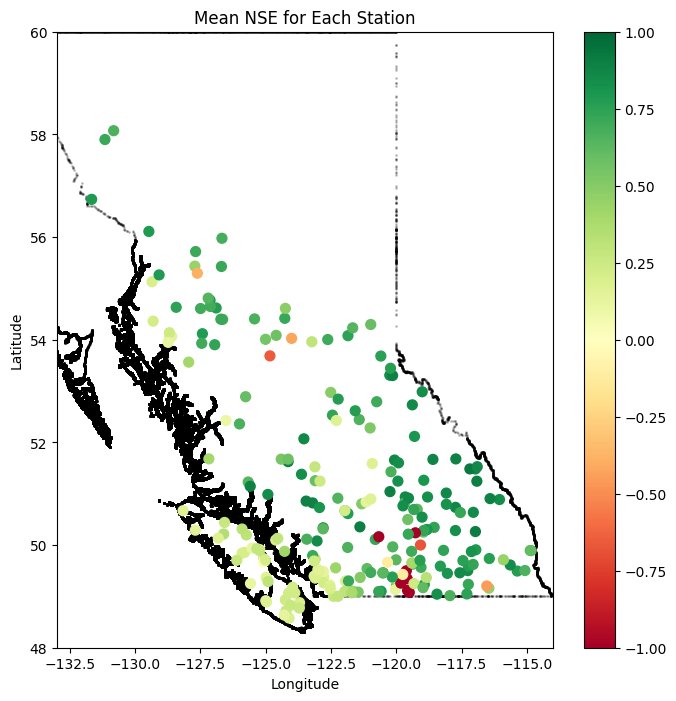

In [247]:
# plot the stations with their lat and lon
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(lons, lats, s=1, c='k', alpha=0.2)
sc = ax.scatter(station_lons.astype(float), station_lats.astype(float), c=mean_ensemble_nse_test, cmap='RdYlGn', vmin=-1, vmax=1, s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mean NSE for Each Station")
plt.xlim(-133, -114)
plt.ylim(48, 60)
plt.colorbar(sc)
# set the colour limits
plt.show()

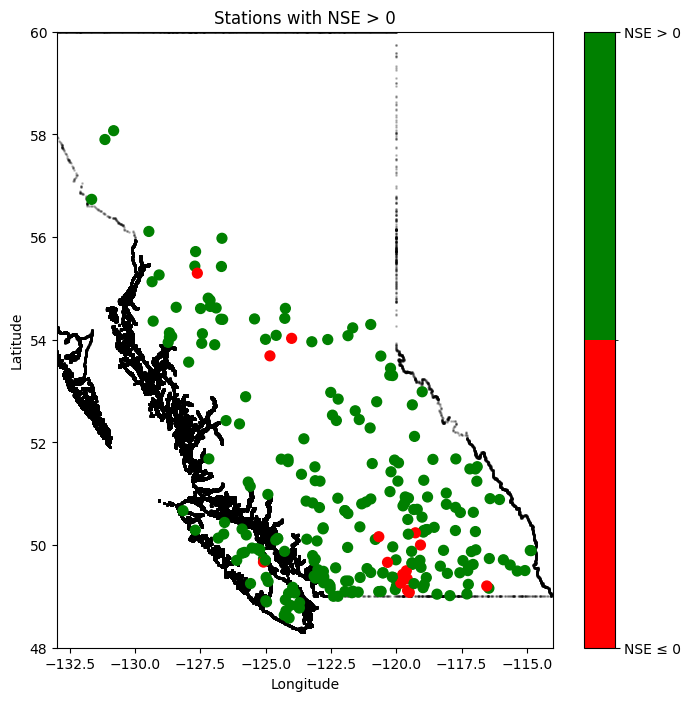

In [274]:
import matplotlib.colors as mcolors

# Create a discrete colormap for binary data
cmap = mcolors.ListedColormap(['red', 'green'])  # Two colors for binary values
bounds = [0, 0.5, 1]  # Boundaries for 0 and 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(lons, lats, s=1, c='k', alpha=0.2)  # Background points
sc = ax.scatter(
    station_lons.astype(float),
    station_lats.astype(float),
    c=mean_ensemble_nse_test > 0,
    cmap=cmap,
    norm=norm,
    s=50,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Stations with NSE > 0")
plt.xlim(-133, -114)
plt.ylim(48, 60)

# Add a color bar
cbar = plt.colorbar(sc, ticks=[0, 1])  # Use ticks for discrete values
cbar.ax.set_yticklabels(['NSE ≤ 0', 'NSE > 0'])  # Label the ticks

plt.show()


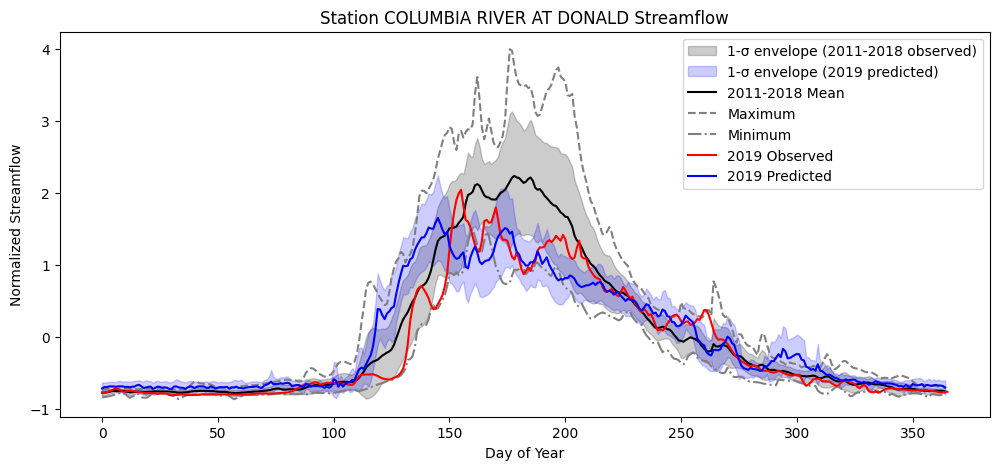

In [329]:
# plot in depth for a station
station_number = 49 #6

station_data = streamflow_data[:, station_number][:9*365].reshape(9, 365)
station_predictions = ensemble_predictions[:, station_number]
station_pred_std = np.std(all_ens_predictions[:,:,station_number], axis=0)
station_max = np.max(station_data, axis=0)
station_min = np.min(station_data, axis=0)
station_mean = np.mean(station_data[:8], axis=0)
station_std = np.std(station_data[:8], axis=0)

plt.figure(figsize=(12, 5))
plt.fill_between(range(365), station_mean - station_std, station_mean + station_std, color='k', alpha=0.2, label='1-σ envelope (2011-2018 observed)')
plt.fill_between(range(365), station_predictions - station_pred_std, station_predictions + station_pred_std, color='b', alpha=0.2, label='1-σ envelope (2019 predicted)')
plt.plot(station_mean, label='2011-2018 Mean', c='k')
plt.plot(station_max, label='Maximum', linestyle='--', c='gray')
plt.plot(station_min, label='Minimum', linestyle='-.', c='gray')
plt.plot(test_true[:, station_number], label='2019 Observed', c='r')
plt.plot(station_predictions, label='2019 Predicted', c='b')
plt.xlabel("Day of Year")
plt.ylabel("Normalized Streamflow")
plt.title(f"Station {station_names[station_number]} Streamflow")
plt.legend()
plt.show()

In [335]:
# compute the nse of the seasonal mean
seasonal_means = np.stack([np.mean(streamflow_data[:, i][:9*365].reshape(9, 365)[:8], axis=0) for i in range(n_stations)])
seasonal_mean_nses = np.array([compute_nse(test_true[:,i][:365], seasonal_means[i]) for i in range(n_stations)])

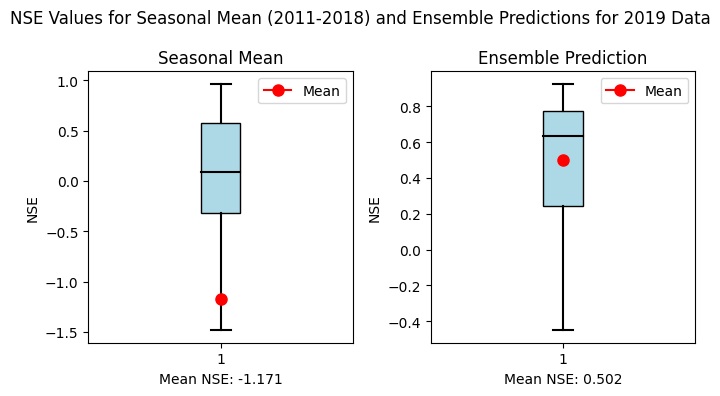

In [338]:
# produce box plots of the NSE values for the seasonal means vs the ensemble predictions
fig, axs = plt.subplots(1, 2, figsize=(7, 4))

# Plot the NSE values for the seasonal means
axs[0].boxplot(seasonal_mean_nses, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black', linewidth=1.5),
               capprops=dict(color='black', linewidth=1.5), medianprops=dict(color='black', linewidth=1.5))
mean_value = np.mean(seasonal_mean_nses)
axs[0].plot(1, mean_value, marker='o', color='red', label="Mean", markersize=8)  # Overlay the mean
axs[0].set_title("Seasonal Mean")
axs[0].set_xlabel("Mean NSE: {:.3f}".format(mean_value))
axs[0].set_ylabel("NSE")
axs[0].legend()

# Plot the NSE values for the ensemble predictions
axs[1].boxplot(mean_ensemble_nse_test_no_outliers, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black', linewidth=1.5),
               capprops=dict(color='black', linewidth=1.5), medianprops=dict(color='black', linewidth=1.5))
mean_value = np.mean(mean_ensemble_nse_test_no_outliers)
axs[1].plot(1, mean_value, marker='o', color='red', label="Mean", markersize=8)  # Overlay the mean
axs[1].set_title("Ensemble Prediction")
axs[1].set_xlabel("Mean NSE: {:.3f}".format(mean_value))
axs[1].set_ylabel("NSE")
axs[1].legend()

plt.suptitle("NSE Values for Seasonal Mean (2011-2018) and Ensemble Predictions for 2019 Data")
plt.tight_layout()
plt.show()

In [367]:
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(test_true.T)
cluster_labels = kmeans.labels_

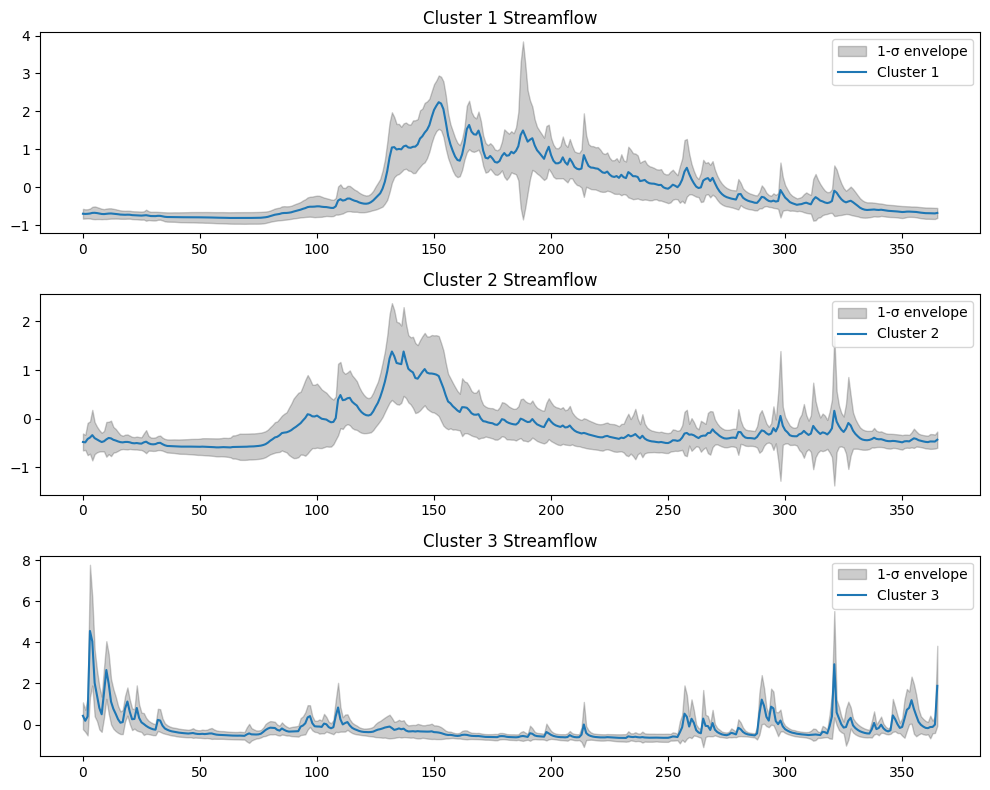

In [372]:
# plot the cluster averages
cluster_means = np.array([np.mean(test_true[:, cluster_labels == i], axis=1) for i in range(n_clusters)])
cluster_std = np.array([np.std(test_true[:, cluster_labels == i], axis=1) for i in range(n_clusters)])

fig, axs = plt.subplots(n_clusters, 1, figsize=(10, 8))
for i in range(n_clusters):
    axs[i].fill_between(range(366), cluster_means[i] - cluster_std[i], cluster_means[i] + cluster_std[i], color='k', alpha=0.2, label='1-σ envelope')
    axs[i].plot(cluster_means[i], label=f'Cluster {i+1}')
    axs[i].set_title(f"Cluster {i+1} Streamflow")
    axs[i].legend()
plt.tight_layout()
plt.show()

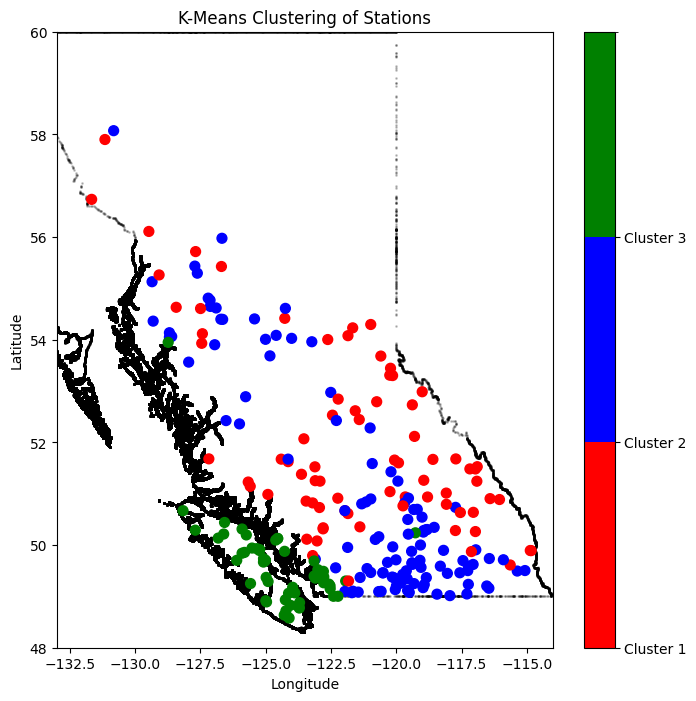

In [347]:
import matplotlib.colors as mcolors

# Define a discrete colormap for clusters
colors = ['red', 'blue', 'green']  # Adjust or add more colors if n_clusters > 3
cmap = mcolors.ListedColormap(colors[:n_clusters])  # Use only as many colors as clusters
bounds = list(range(n_clusters + 1))  # One boundary for each cluster
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the clustering results
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(lons, lats, s=1, c='k', alpha=0.2)  # Background points
sc = ax.scatter(
    station_lons.astype(float),
    station_lats.astype(float),
    c=cluster_labels,
    cmap=cmap,
    norm=norm,
    s=50,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering of Stations")
plt.xlim(-133, -114)
plt.ylim(48, 60)

# Add a discrete color bar
cbar = plt.colorbar(sc, ticks=list(range(n_clusters)))
cbar.ax.set_yticklabels([f"Cluster {i+1}" for i in range(n_clusters)])  # Label each cluster

plt.show()


In [355]:
ensemble_predictions_test.shape

(366, 241)

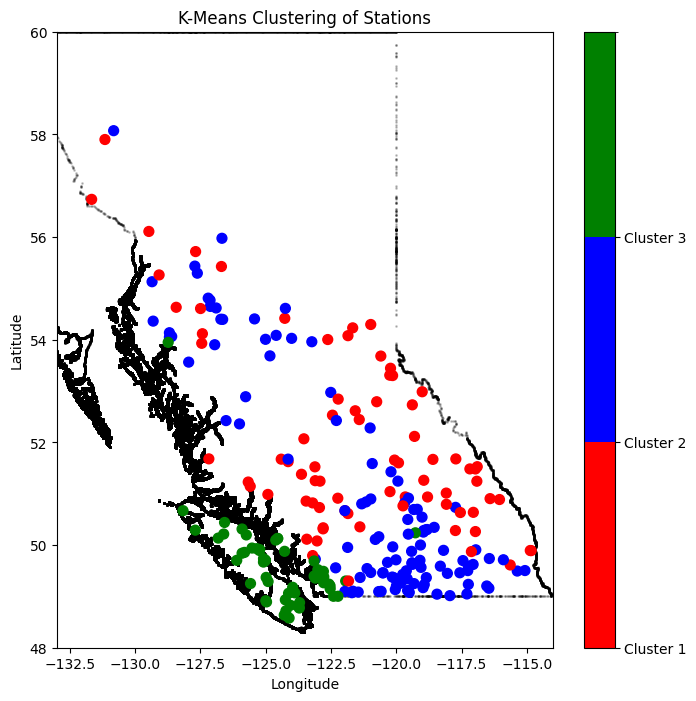

In [364]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(ensemble_predictions_test.T)
cluster_labels_pred = kmeans.labels_

# Define a discrete colormap for clusters
colors = ['red', 'blue', 'green']  # Adjust or add more colors if n_clusters > 3
cmap = mcolors.ListedColormap(colors[:n_clusters])  # Use only as many colors as clusters
bounds = list(range(n_clusters + 1))  # One boundary for each cluster
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the clustering results
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(lons, lats, s=1, c='k', alpha=0.2)  # Background points
sc = ax.scatter(
    station_lons.astype(float),
    station_lats.astype(float),
    c=cluster_labels,
    cmap=cmap,
    norm=norm,
    s=50,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering of Stations")
plt.xlim(-133, -114)
plt.ylim(48, 60)

# Add a discrete color bar
cbar = plt.colorbar(sc, ticks=list(range(n_clusters)))
cbar.ax.set_yticklabels([f"Cluster {i+1}" for i in range(n_clusters)])  # Label each cluster

plt.show()


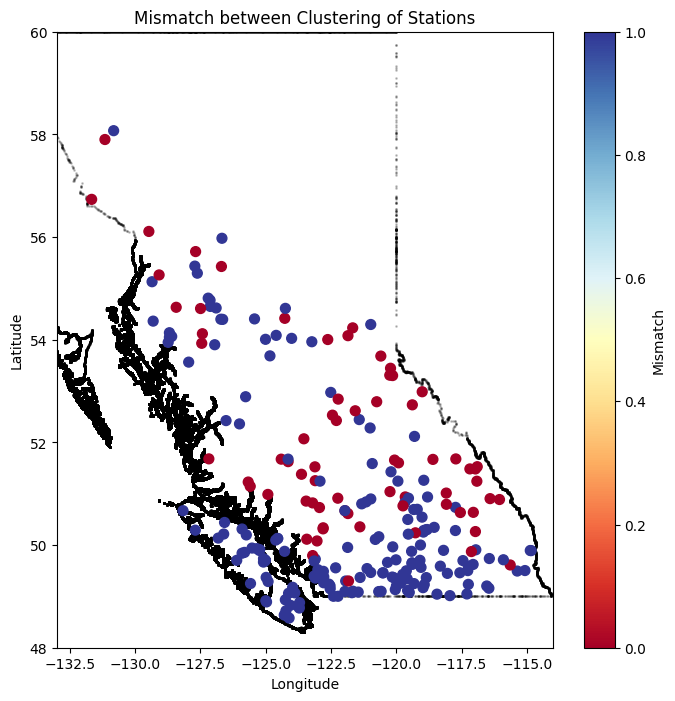

In [366]:
mask = cluster_labels_pred - cluster_labels != 0

# plot mask on the map
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(lons, lats, s=1, c='k', alpha=0.2)  # Background points
sc = ax.scatter(
    station_lons.astype(float),
    station_lats.astype(float),
    c=mask,
    cmap='RdYlBu',
    s=50,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mismatch between Clustering of Stations")
plt.xlim(-133, -114)
plt.ylim(48, 60)

# Add a color bar
cbar = plt.colorbar(sc)
cbar.set_label("Mismatch")
plt.show()


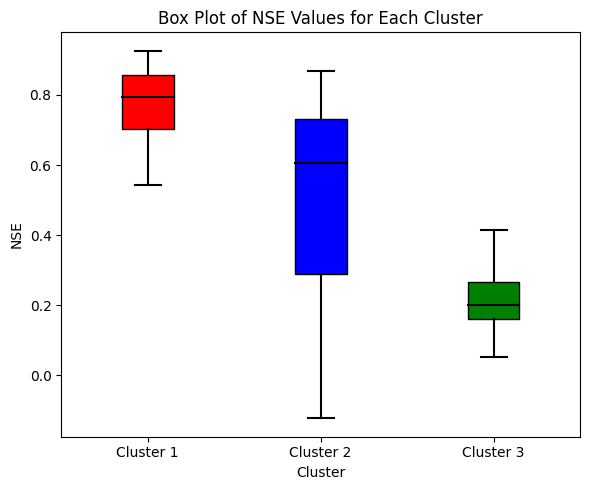

In [353]:
import matplotlib.pyplot as plt

# Define colors matching the clusters
colors = ['red', 'blue', 'green']  # Adjust or add more colors if n_clusters > 3

# Create a box plot of the NSE values for each cluster
nse_clusters = [mean_ensemble_nse_test[cluster_labels == i] for i in range(n_clusters)]

fig, ax = plt.subplots(figsize=(6, 5))
boxplot = ax.boxplot(
    nse_clusters,
    showfliers=False,
    patch_artist=True,  # Allows custom colors for the boxes
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    medianprops=dict(color='black', linewidth=1.5),
)

# Set box colors to match the cluster colors
for patch, color in zip(boxplot['boxes'], colors[:n_clusters]):
    patch.set_facecolor(color)

# Add labels and title
ax.set_title("Box Plot of NSE Values for Each Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("NSE")
ax.set_xticks(range(1, n_clusters + 1))
ax.set_xticklabels([f"Cluster {i+1}" for i in range(n_clusters)])

plt.tight_layout()
plt.show()
